In [1]:
import os
import sys

sys.path.append('/Users/samrelins/Documents/LIDA/dental_project/src/')

from baseline_data_prep import *
from education_data_prep import *
from ga_data_prep import *
from naive_model_helpers import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
bib_dir = "/Users/samrelins/Documents/LIDA/dental_project/data/bib_data/"
edrecs_ga = return_merged_edrecs_ga_df(bib_dir, drop_comp_care_cases=True)

# GA Prediction - Initial Models

Our plan A for the dental project is to merge the GA data with the observations in BiB data, and use this data to highlight predictors of GA outcomes. With that in mind, initially I ran some quick models to establish the degree to which the GA outcomes can be predicted using the BiB data:

## Education Data

The first of the datasets I received was the full "BiB Education Record". After cleaning, pre-processing and merging each of the dataframes, it comprises:

 - 10,047 of the 13,858 total children in the BiB cohort
 - 777 of the 932 unique exodontia patients in the GA dataset

and variables / observations as follows:

| Variable | Description | Values |
|---|---|---|
| com_listening_attention |EYFSP- Communication and language: Listening and attention | Below or Mising / Expected / Exceeding |
| com_understanding | EYFSP- Communication and language: Understanding | Below or Mising / Expected / Exceeding |
| com_speaking | EYFSP- Communication and language: Speaking | Below or Mising / Expected / Exceeding |
| exp_using_media_materials | EYFSP- Expressive arts and design: Exploring and using media and materials | Below or Mising / Expected / Exceeding |
| exp_being_imaginative | EYFSP- Expressive arts and design: Being imaginative | Below or Mising / Expected / Exceeding |
| lit_reading | EYFSP- Literacy: Reading | Below or Mising / Expected / Exceeding |
| lit_writing | EYFSP- Literacy: Writing | Below or Mising / Expected / Exceeding |
| mat_numbers | EYFSP- Mathematics: Numbers | Below or Mising / Expected / Exceeding |
| mat_shapes_space_measures | EYFSP- Mathematics: Shapes, space and measures | Below or Mising / Expected / Exceeding |
| phy_moving_handling | EYFSP- Physical development: Moving and handling | Below or Mising / Expected / Exceeding |
| phy_health_self_care | EYFSP- Physical development: Health and self-care | Below or Mising / Expected / Exceeding |
| pse_self_confidence_awareness | EYFSP- Personal, social and emotional: Self-confidence and self-awareness | Below or Mising / Expected / Exceeding |
| pse_managing_feelings_behaviour | EYFSP- Personal, social and emotional: Managing feelings and behaviour | Below or Mising / Expected / Exceeding |
| pse_making_relationships | EYFSP- Personal, social and emotional: Making relationships | Below or Mising / Expected / Exceeding |
| utw_people_communities | EYFSP- Understanding the world: People and communities | Below or Mising / Expected / Exceeding |
| utw_the_world | EYFSP- Understanding the world: The world | Below or Mising / Expected / Exceeding | Below or Mising / Expected / Exceeding |
| utw_technology |EYFSP- Understanding the world: Technology | Below or Mising / Expected / Exceeding |
| year_started_school | Academic year started school | 2011-2015 |
| eal |Whether English is an additional language | No / Unknown / Yes |
| ethnicity | Child Ethnic Origin | White British / Pakistani / Other |
| fsm | Whether child in receipt of freee school meals | Yes / No |
| gifted | Whether recorded as 'gifted and talented' child | Yes / No |
| male | Child gender male | Yes / No |
| looked_after | Whether looked after child | Yes / No |
| sen | Has special educational needs | Yes / No |
| phonics_grade1 | Phonics test grade - Test 1 |  Below or Missing / Expected |
| phonics_mark1 | Phonics Test Mark - Test 1 | 0-40 |
| meets_phonics_standard | Whether reached phonics standard - Test 1 | Yes / No |
| ks1_maths | Key Stage 1 (pre 2016 and post 2016 merged)- Maths | Below or Missing / Expected / Exceeding |
| ks1_reading | Key Stage 1 (pre/post 2016 merged)- Reading |  Below or Missing / Expected / Exceeding |
| ks1_writing | Key Stage 1 (pre/post 2016 merged)- Writing |  Below or Missing / Expected / Exceeding |

### Linear Modelling Approach

To begin, I trained a logistic regression model, with the logic that an initial linear approach would be:

1. **simple** - it assumes the input variables are independent given the outcome / target, and so tends to "underfit" the data, giving a good "baseline"/ conservative estimate of the predictive potential of the input data
2. **interpretable** - Its easy to compute robust statistics from linear models that highlight important input variables - which have the greatest influence on outcomes, and which of these influences is statistically significant
3. **predictable** - The training performance of a logistic regression model is guaranteed to be either the same or better as you add input variables, and so won't be harmed by a "chuck everything in and see what happens" approach

### Education Logistic Regression Results:

Full statistics for the Education logistic regresion model can be seen in the appendices. In summary:

* The model has a **log-likelihood ratio p-value of 9.4e-7 i.e. is deemed to be highly statistically significant**
* using all 56 free parameters in the education data achieves a training **R-squared value of approx 0.036** - this can be interpreted as saying *"the full education dataset explains around 3.6% (barely any) of the variability in GA outcomes"*
* The model achieves an **ROC/AUC (a measure of  true/false positive predictions) of approx 0.59 against a holdout test set**. Random guessing will, on average, result in an ROC/AUC of 0.5.

In short, the education data has a highly statistically significant relationship with GA outcomes, but that relationship has only a very small influence on GA outcomes.

In [3]:
edrecs_train, edrecs_test = train_test_split_by_ga(edrecs_ga)
edrecs_lr = log_reg_model_of_ga(edrecs_train)

Optimization terminated successfully.
         Current function value: 0.263351
         Iterations 16


In [4]:
edrecs_y_test, edrecs_X_test = patsify_data(edrecs_test)
preds = edrecs_lr.predict(edrecs_X_test)
roc_auc_score(edrecs_y_test, preds)

0.591833256740196

### Visualising significant variables:

Visualising some of the variables the logistic regression model identifies as significant is helpful in explaining this poor predictive performance:

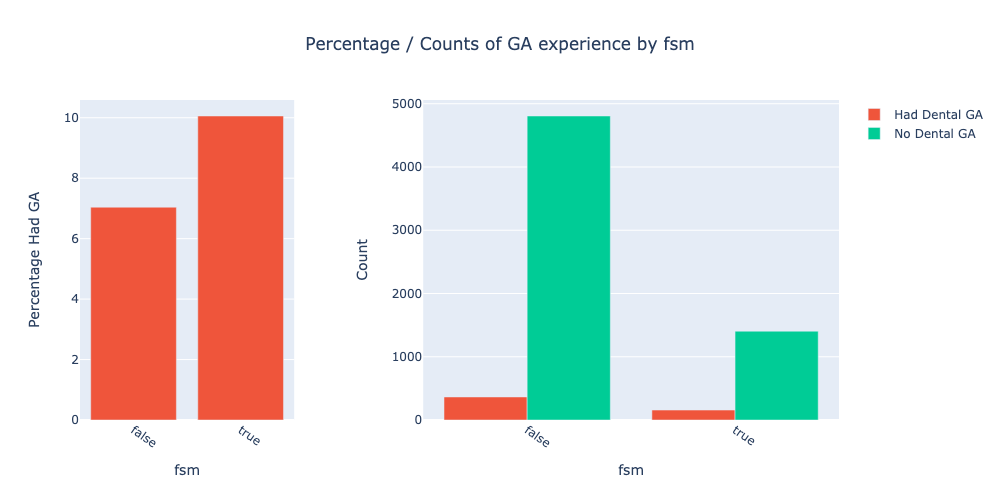

In [5]:
plot_ga_rate_comparison(edrecs_train, "fsm")

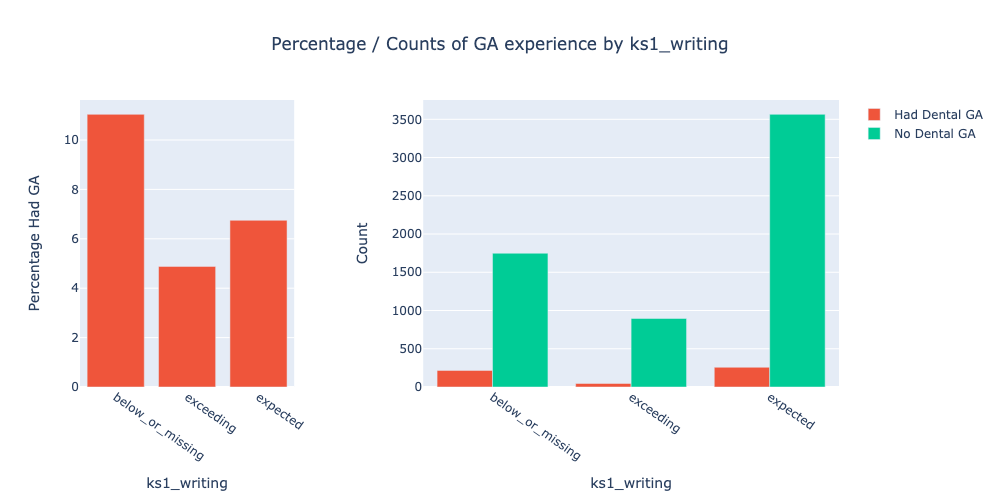

In [6]:
plot_ga_rate_comparison(edrecs_train, "ks1_writing")

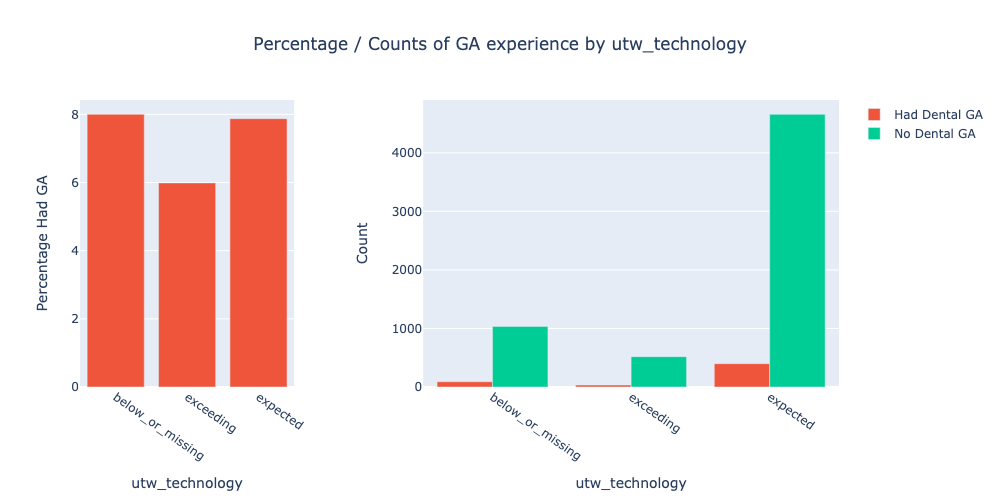

In [7]:
plot_ga_rate_comparison(edrecs_train, "utw_technology")

Note that, in each case we observe one/both of the following:
* though the percentages of GA experience are different between the categories, the absolute percentages are still very low (<12%) and so the effect on overall risk for each group remains low
* the counts of children in each category can differ widely - significant predictors usually represent only a small fraction of the population in the dataset

### Non Linear Approaches

A possible explanation for the poor performance of linear models is a highly non-linear relationship between the input variables and the outcomes. There may, for example, be significant interaction effects among the input variables that aren't captured by the logistic regression model and that, similarly, are difficult to visualise.

To address this possibility, I also trained a Gradient Boosted Decision Tree Ensemble Classifier (method redacted for brevity). The ensemble achieved a **test set ROC/AUC of approx 0.62** - little appreciable performance improvement from the logistic regression baseline. Therefore, it doesn't appear that there are any strong interaction effects hiding in the Education data that were missed by the linear model.

In [8]:

param_grid = {"n_estimators": [10, 30, 100, 130],
              "max_depth": [2, 4, 10, 14],
              "min_samples_split": [100, 300, 1000, 1300],
              "max_features": [5, 10, 15, 20, 25]}

gb_clf = GradientBoostingClassifier()
cv_clf = GridSearchCV(gb_clf,
                      param_grid,
                      scoring="roc_auc",
                      n_jobs=14,
                      verbose=1)

edrecs_y_train, edrecs_X_train = patsify_data(edrecs_train)
cv_clf.fit(edrecs_X_train,
           edrecs_y_train.has_dental_ga)
cv_clf.best_params_
cv_clf.best_score_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    7.9s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   19.6s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   33.8s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   58.7s
[Parallel(n_jobs=14)]: Done 1600 out of 1600 | elapsed:  1.4min finished


0.5983536759804876

In [9]:
preds = cv_clf.predict_proba(edrecs_X_test)[:,1]
roc_auc_score(edrecs_y_test, preds)

0.6254978553921569


## Baseline Data

Another resonable explanation for the poor performance of the initial model is the data itself - the education data doesn't contain the right information to predict GA outcomes. In response, I asked for, and received, data from the "Mother Baseline Survey":

 - Mothers of 11,474 of the 13,858 children in the BiB cohort
 - Mothers of 741 of the 932 unique exodontia patients in the GA data
 - 342 variables / observations

From the 342 variables I selected 12 that are the most generalised of the information in the baseline questionnaire, and are relatively complete. This reduces the survey data to:

 - Mothers of 9,997 of the BiB Cohort
 - Mothers of 645 of the unique exodontia GA patients

the selected variables are as follows:

| Variable | Description | Values |
|---|---|---|
| on_benefits | In receipt of benefits / tax credit | Yes / No |
| fathers_education | Baby’s father’s highest educational qualification (equivalised) | <5 GCSE equivalent / GCSE equivalent / A-level equivalent / Higher than A-level / Other / Don’t know / Foreign Unknown |
| mothers_education | Mother’s highest educational qualification (equivalised) | <5 GCSE equivalent / GCSE equivalent / A-level equivalent / Higher than A-level / Other / Don’t know / Foreign Unknown |
| mothers_ethnicity | Mother’s ethnic group - 3 categories | White British / Pakistani / Other |
| managing_financially | How well mother and husband/partner managing financially | Living comfortably / Doing alright / Just about getting by / Quite difficult / Very difficult / Does not wish to answer |
| married_cohabiting | Marital and cohabitation status combined (derived) | Married and living with partner / Not married and living with partner / Not living with partner |
| imd_2010_decile_nat | IMD 2010 decile | 1-10 |
| father_employment | Father’s employment status | Employed-Non-Manual / Employed-Manual / Self-employed / Student / Unemployed / Don’t know |
| mother_employment | Mother's employment status | Currently employed / Previously employed / Never employed |
| socio_economic_pos | Socio-economic position (5 group LCA) | Least dep and most educated / Employed not mat dep / Employed no access to money / Benefits but coping / Most dep |
| mothers_bmi | Mother’s booking BMI (derived) | 12-57 |
| mother_smoked | Mother ever regularly smoked | Yes, more than 1 year / Yes, less than 1 year / Yes, not specified / No |

In [10]:
# load baseline / ga data points of interest
cols_of_interest = ['entity_id', "BiBPregNumber", 'ben0nobenf', 'edu0fthede',
                    'edu0mumede', "eth0eth3gp", "fin0manfin",
                    'hhd0marchb', 'imd_2010_decile_nat', 'job0fthemp',
                    'job0mumemp', 'mbqlcasep5gp', "mms0mbkbmi", "smk0regsmk"]

education_outcomes = {1: "<5_gcse", 2: "5_gcse", 3: "A_level",
                      4: "higher_than_A_level", 5: "other", 6: "dont_know",
                      7: "foreign_unknown"}

rename_features = {
    "ben0nobenf": ("on_benefits", {1: "no",
                                   2: "yes"}),
    "edu0fthede": ("fathers_education", education_outcomes),
    "edu0mumede": ("mothers_education", education_outcomes),
    "eth0eth3gp": ("mothers_ethnicity", {1:"white_british",
                                 2: "pakistani",
                                 3: "other"}),
    "fin0manfin": ("managing_financially", {1: "living_comfortably",
                                            2: "doing_alright",
                                            3: "just_about_getting_by",
                                            4: "quite_difficult",
                                            5: "very_difficult",
                                            6: "no_answer"}),
    "hhd0marchb": ("married_cohabiting", {1: "married_n_cohabiting",
                                         2: "married_not_cohabiting",
                                         3: "not_cohabiting"}),
    "imd_2010_decile_nat": ("imd_decile", None),
    "job0fthemp": ("father_employment", {1: "non_manual",
                                         2: "manual",
                                         3: "self_employed",
                                         4: "student",
                                         5: "unemployed",
                                         6: "unknown"}),
    "job0mumemp": ("mother_employment", {1: "currently_employed",
                                         2: "previously_employed",
                                         3: "never_employed"}),
    "mbqlcasep5gp": ("socio_economic_pos", {1: "least_dep_most_edu",
                                            2: "employed_not_dep",
                                            3: "employed_dep",
                                            4: "benefits",
                                            5: "most_dep"}),
    "mms0mbkbmi": ("mothers_bmi", None),
    "smk0regsmk": ("mother_smoked", {1: "yes_over_year_ago",
                                     2: "yes_within_year",
                                     3: "yes",
                                     4: "no"})
}


baseline_ga = return_merged_baseline_ga_df(bib_dir, cols_of_interest,
                                             drop_comp_care_cases=True)
for feature in rename_features.keys():
    name, map = rename_features[feature]
    if map is not None:
        baseline_ga[name] = baseline_ga[feature].map(map).astype("category")
    else:
        baseline_ga[name] = baseline_ga[feature].astype("float")
    baseline_ga.drop(feature, axis=1, inplace=True)

baseline_ga.info()

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning:

Columns (110,247,303) have mixed types.Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9996
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   entity_id             9997 non-null   object  
 1   has_dental_ga         9997 non-null   float64 
 2   on_benefits           9997 non-null   category
 3   fathers_education     9997 non-null   category
 4   mothers_education     9997 non-null   category
 5   mothers_ethnicity     9997 non-null   category
 6   managing_financially  9997 non-null   category
 7   married_cohabiting    9997 non-null   category
 8   imd_decile            9997 non-null   float64 
 9   father_employment     9997 non-null   category
 10  mother_employment     9997 non-null   category
 11  socio_economic_pos    9997 non-null   category
 12  mothers_bmi           9997 non-null   float64 
 13  mother_smoked         9997 non-null   category
dtypes: category(10), float64(3), object(1)
memory usage: 490

In [11]:
baseline_ga.has_dental_ga.sum()

645.0

## Baseline Logistic Regression Model

As before, I fit a simple logistic regression model using this data and full results can be seen in the appendices. In summary:

* The model achieves a **log likelihood ratio p-value of 7.4e-11 i.e. again, it is highly statistically significant**
* The pseudo **R-squared value is 0.038** - again very little of the variance in GA risk (3.8%) is explaned by the model
* The test dataset **ROC/AUC is 0.62** - very similar to the education models

In short, the results are effectively the same as with the education data - a highly significant relationship between the data and outcomes, but one that describes only small changes in the chance of a GA outcome.

In [12]:
baseline_train, baseline_test = train_test_split_by_ga(baseline_ga)
baseline_lr = log_reg_model_of_ga(baseline_train)

Optimization terminated successfully.
         Current function value: 0.230027
         Iterations 8


In [13]:
base_y_test, base_X_test = patsify_data(baseline_test)
preds = baseline_lr.predict(base_X_test)
roc_auc_score(base_y_test, preds)


0.6289490533526175

## Significant Baseline Variables:

As before, we can take a look at some of the significant freatures of the logistic regression model:

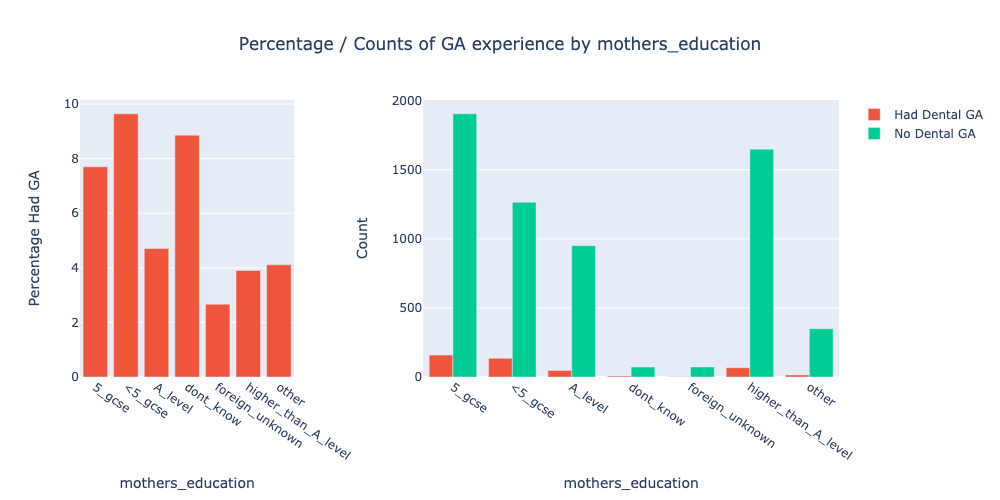

In [14]:
plot_ga_rate_comparison(baseline_train, "mothers_education")

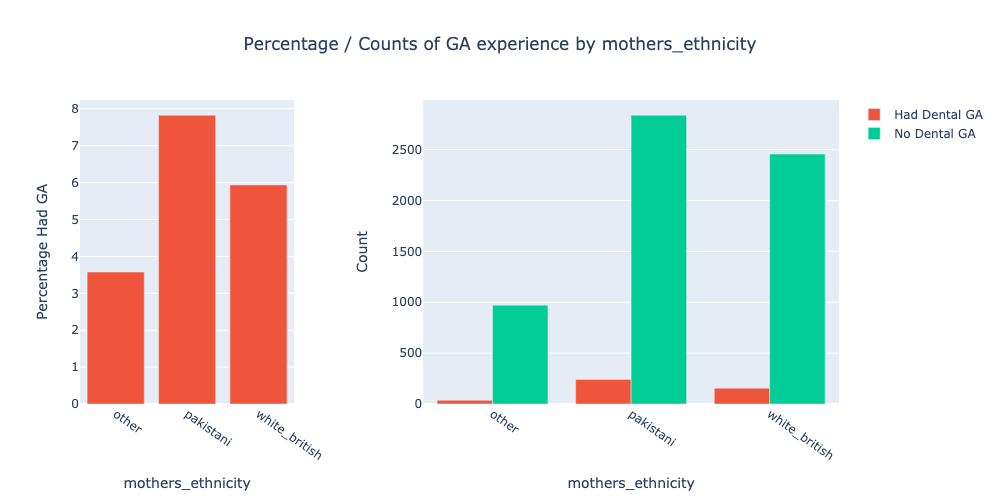

In [15]:
plot_ga_rate_comparison(baseline_train, "mothers_ethnicity")

as before, the proportions of patients experiencing GA are small in each group, and the significant groups represent only small proportions of the overall population

## Baseline Tree Ensemble:

As with the education data, I checked for evidence of non-linear relationships using a Gradient Boosted Decision Tree ensemble. The **ROC/AUC achieved was 0.628**, again suggesting there aren't any non-linear interactions / relationships being overlooked by the logistic regression model.

In [16]:
gb_clf = GradientBoostingClassifier()
cv_clf = GridSearchCV(gb_clf,
                      param_grid,
                      scoring="roc_auc",
                      n_jobs=14,
                      verbose=1)

base_y_train, base_X_train = patsify_data(baseline_train)
cv_clf.fit(base_X_train,
           base_y_train.has_dental_ga)
cv_clf.best_params_
cv_clf.best_score_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=14)]: Done 316 tasks      | elapsed:    6.9s
[Parallel(n_jobs=14)]: Done 702 tasks      | elapsed:   19.7s
[Parallel(n_jobs=14)]: Done 1052 tasks      | elapsed:   37.7s
[Parallel(n_jobs=14)]: Done 1502 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 1600 out of 1600 | elapsed:  1.3min finished


0.6237891290253832

In [17]:
preds = cv_clf.predict_proba(base_X_test)[:,1]
roc_auc_score(base_y_test, preds)

0.6288501986978561

## Merging Education and Baseline Survey Data

Finally, I combined the two datasets and applied the same modelling approach I used when testing them separately . Merging the datasets reduced the number of complete examples to 7302, and the number of children with a GA to 546. The subsequent modelling results were:

* **Logistic Regresssion** - Log-likelihood 6.1e-11 - pseudo R-squared 0.079 - ROC/AUC 0.62
* **Gradient Boosted Tree Ensemble** - ROC/AUC 0.631

*(full results in appendices)*

A small improvement, but not sufficient to see dramatically better predictive potential.

In [28]:
edrecs_baseline_ga = (baseline_ga.merge(
    edrecs_ga.drop("has_dental_ga", axis=1),
    on="entity_id",
    how="left").dropna())

In [19]:
edrecs_baseline_ga.has_dental_ga.sum()

546.0

In [20]:
drop_cols = ["year_started_school"]

eb_train, eb_test = train_test_split_by_ga(
    edrecs_baseline_ga.drop(drop_cols, axis=1))
eb_lr = log_reg_model_of_ga(eb_train);

         Current function value: 0.244984
         Iterations: 100


/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [21]:
eb_y_test, eb_X_test = patsify_data(eb_test)
preds = eb_lr.predict(eb_X_test)
roc_auc_score(eb_y_test, preds)

0.6183233682112607

In [22]:
gb_clf = GradientBoostingClassifier()
cv_clf = GridSearchCV(gb_clf,
                      param_grid,
                      scoring="roc_auc",
                      n_jobs=14,
                      verbose=1)

eb_y_train, eb_X_train = patsify_data(eb_train)
cv_clf.fit(eb_X_train,
           eb_y_train.has_dental_ga)
cv_clf.best_params_
cv_clf.best_score_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=14)]: Done 316 tasks      | elapsed:    7.0s
[Parallel(n_jobs=14)]: Done 632 tasks      | elapsed:   15.8s
[Parallel(n_jobs=14)]: Done 982 tasks      | elapsed:   28.9s
[Parallel(n_jobs=14)]: Done 1432 tasks      | elapsed:   50.4s
[Parallel(n_jobs=14)]: Done 1600 out of 1600 | elapsed:  1.1min finished


0.6462340873655188

In [23]:
preds = cv_clf.predict_proba(eb_X_test)[:,1]
roc_auc_score(eb_y_test, preds)

0.627405331340309

## Final Thoughts

* The models do seem to indicate a relationship between the BiB variables tested and GA outcomes, though the effect of the variables is minimal
* Using an data-driven approach to building a DAG will require a stronger relationship between the input variables and outcomes - otherwise, the methods used to infer DAG structure will likely favour graphs / distributions in which GA is an independent variable to minimise complexity

## Appendix

### Education Records Logistic Regression Results:

In [31]:
display(edrecs_lr.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_dental_ga   No. Observations:                 6731
Model:                          Logit   Df Residuals:                     6674
Method:                           MLE   Df Model:                           56
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                 0.03315
Time:                        14:55:18   Log-Likelihood:                -1772.6
converged:                       True   LL-Null:                       -1833.4
Covariance Type:            nonrobust   LLR p-value:                 9.438e-07
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     -150.4366   4.22e+06  -3.57e-05      1.000   -8.27e+06    8.27e+06
com_listening_attention[T.exceeding]            -0.0220      0.340     -0.065      0.948      -0.688       0.644
com_listening_attention[T.expected]              0.2337      0.226      1.036      0.300      -0.208       0.676
com_understanding[T.exceeding]                   0.1756      0.373      0.471      0.637      -0.555       0.906
com_understanding[T.expected]                   -0.2213      0.258     -0.858      0.391      -0.727       0.284
com_speaking[T.exceeding]                       -0.2704      0.344     -0.786      0.432      -0.945       0.404
com_speaking[T.expected]                         0.2279      0.227      1.002      0.316      -0.218       0.674
exp_using_media_materials[T.exceeding]           0.1076      0.323      0.333      0.739      -0.525       0.740
exp_using_media_materials[T.expected]            0.1325      0.197      0.672      0.501      -0.254       0.519
exp_being_imaginative[T.exceeding]               0.0617      0.352      0.175      0.861      -0.628       0.752
exp_being_imaginative[T.expected]                0.0017      0.197      0.009      0.993      -0.384       0.387
lit_reading[T.exceeding]                        -0.5631      0.330     -1.706      0.088      -1.210       0.084
lit_reading[T.expected]                         -0.0241      0.197     -0.122      0.903      -0.410       0.362
lit_writing[T.exceeding]                        -0.0865      0.350     -0.247      0.805      -0.773       0.600
lit_writing[T.expected]                         -0.3070      0.186     -1.647      0.100      -0.672       0.058
mat_numbers[T.exceeding]                         0.1120      0.340      0.329      0.742      -0.555       0.779
mat_numbers[T.expected]                          0.0878      0.199      0.442      0.659      -0.302       0.478
mat_shapes_space_measures[T.exceeding]           0.2289      0.372      0.616      0.538      -0.499       0.957
mat_shapes_space_measures[T.expected]           -0.0259      0.210     -0.123      0.902      -0.438       0.386
phy_moving_handling[T.exceeding]                -0.0095      0.269     -0.035      0.972      -0.536       0.517
phy_moving_handling[T.expected]                 -0.0907      0.180     -0.505      0.613      -0.443       0.261
phy_health_self_care[T.exceeding]               -0.1116      0.289     -0.386      0.700      -0.679       0.456
phy_health_self_care[T.expected]                -0.2962      0.197     -1.506      0.132      -0.682       0.089
pse_self_confidence_awareness[T.exceeding]       0.1027      0.301      0.341      0.733      -0.488       0.693
pse_self_confidence_awareness[T.expected]        0.0467      0.203      0.230      0.818      -0.351       0.445
pse_managing_feelings_behaviour[T.exceeding]    -0.0587      0.342     -0.172

### Baseline Survey Logistic Regression Results:

In [32]:
display(baseline_lr.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_dental_ga   No. Observations:                 6697
Model:                          Logit   Df Residuals:                     6658
Method:                           MLE   Df Model:                           38
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                 0.03832
Time:                        14:55:23   Log-Likelihood:                -1540.5
converged:                       True   LL-Null:                       -1601.9
Covariance Type:            nonrobust   LLR p-value:                 7.403e-11
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.5507      0.369     -6.915      0.000      -3.274      -1.828
on_benefits[T.yes]                               -0.0165      0.123     -0.134      0.893      -0.257       0.224
fathers_education[T.<5_gcse]                      0.1822      0.154      1.180      0.238      -0.120       0.485
fathers_education[T.A_level]                     -0.2972      0.215     -1.385      0.166      -0.718       0.123
fathers_education[T.dont_know]                    0.2147      0.145      1.478      0.139      -0.070       0.499
fathers_education[T.foreign_unknown]             -1.2316      1.045     -1.178      0.239      -3.280       0.817
fathers_education[T.higher_than_A_level]         -0.4876      0.212     -2.299      0.021      -0.903      -0.072
fathers_education[T.other]                        0.0850      0.278      0.306      0.759      -0.459       0.629
mothers_education[T.<5_gcse]                      0.0610      0.131      0.464      0.643      -0.197       0.318
mothers_education[T.A_level]                     -0.3194      0.178     -1.795      0.073      -0.668       0.029
mothers_education[T.dont_know]                   -0.0545      0.412     -0.132      0.895      -0.863       0.754
mothers_education[T.foreign_unknown]             -0.2719      0.760     -0.358      0.720      -1.761       1.217
mothers_education[T.higher_than_A_level]         -0.3754      0.177     -2.122      0.034      -0.722      -0.029
mothers_education[T.other]                       -0.4865      0.284     -1.715      0.086      -1.043       0.070
mothers_ethnicity[T.pakistani]                    0.5350      0.199      2.689      0.007       0.145       0.925
mothers_ethnicity[T.white_british]                0.4116      0.215      1.913      0.056      -0.010       0.833
managing_financially[T.just_about_getting_by]     0.0595      0.131      0.453      0.650      -0.198       0.317
managing_financially[T.living_comfortably]        0.0147      0.134      0.110      0.913      -0.248       0.278
managing_financially[T.no_answer]                -0.2775      1.051     -0.264      0.792      -2.338       1.782
managing_financially[T.quite_difficult]           0.0580      0.225      0.258      0.797      -0.383       0.499
managing_financially[T.very_difficult]            0.0223      0.375      0.059      0.953      -0.713       0.757
married_cohabiting[T.married_not_cohabiting]     -0.2465      0.193     -1.279      0.201      -0.624       0.131
married_cohabiting[T.not_cohabiting]              0.1369      0.170      0.805      0.421      -0.197       0.470
father_employment[T.non_manual]                  -0.1752      0.134     -1.308      0.191      -0.438       0.087
father_employment[T.self_employed]               -0.1354      0.156     -0.869      0.385      -0.441       0.170
father_employment[T.student]                     

### Merged Baseline + Education Logistic Regression Results:

In [33]:
display(eb_lr.summary())




<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          has_dental_ga   No. Observations:                 4892
Model:                          Logit   Df Residuals:                     4801
Method:                           MLE   Df Model:                           90
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                 0.07874
Time:                        14:55:30   Log-Likelihood:                -1198.5
converged:                      False   LL-Null:                       -1300.9
Covariance Type:            nonrobust   LLR p-value:                 6.144e-11
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.6644      0.515     -5.173      0.000      -3.674      -1.655
on_benefits[T.yes]                               -0.2036      0.137     -1.481      0.139      -0.473       0.066
fathers_education[T.<5_gcse]                      0.0827      0.168      0.492      0.623      -0.247       0.412
fathers_education[T.A_level]                     -0.3110      0.239     -1.301      0.193      -0.779       0.157
fathers_education[T.dont_know]                    0.1065      0.162      0.658      0.511      -0.211       0.424
fathers_education[T.foreign_unknown]              0.1230      0.767      0.160      0.873      -1.381       1.627
fathers_education[T.higher_than_A_level]         -0.4718      0.235     -2.008      0.045      -0.932      -0.011
fathers_education[T.other]                       -0.4035      0.371     -1.088      0.277      -1.130       0.323
mothers_education[T.<5_gcse]                      0.1718      0.146      1.180      0.238      -0.113       0.457
mothers_education[T.A_level]                      0.0300      0.189      0.158      0.874      -0.341       0.401
mothers_education[T.dont_know]                   -0.1026      0.494     -0.208      0.835      -1.071       0.865
mothers_education[T.foreign_unknown]            -21.1142   2.43e+04     -0.001      0.999   -4.76e+04    4.75e+04
mothers_education[T.higher_than_A_level]         -0.1933      0.197     -0.983      0.326      -0.579       0.192
mothers_education[T.other]                       -0.5900      0.366     -1.614      0.107      -1.307       0.127
mothers_ethnicity[T.pakistani]                   -0.2120      0.417     -0.508      0.612      -1.030       0.606
mothers_ethnicity[T.white_british]                0.2018      0.364      0.554      0.580      -0.512       0.916
managing_financially[T.just_about_getting_by]     0.0696      0.148      0.471      0.637      -0.220       0.359
managing_financially[T.living_comfortably]        0.0079      0.150      0.052      0.958      -0.287       0.302
managing_financially[T.no_answer]                -0.4129      1.101     -0.375      0.708      -2.570       1.744
managing_financially[T.quite_difficult]           0.1572      0.246      0.638      0.524      -0.326       0.640
managing_financially[T.very_difficult]            0.3270      0.361      0.907      0.364      -0.380       1.034
married_cohabiting[T.married_not_cohabiting]     -0.1844      0.218     -0.847      0.397      -0.611       0.243
married_cohabiting[T.not_cohabiting]              0.1525      0.198      0.770      0.441      -0.236       0.540
father_employment[T.non_manual]                  -0.0440      0.152     -0.289      0.773      -0.343       0.255
father_employment[T.self_employed]                0.1927      0.167      1.154      0.248      -0.135       0.520
father_employment[T.student]                    -